# 导入数据库

In [1]:
#数据处理库
import numpy as np
import pandas as pd
import glob
import re
import jieba

#可视化库
import stylecloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.globals import ThemeType 
from IPython.display import Image
from palettable.colorbrewer.qualitative import Pastel1_7
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

#文本挖掘库
from snownlp import SnowNLP
from gensim import corpora,models
import csv

# 数据导入

In [2]:
df = pd.read_excel('D:\\情感分析\\data\\波动期.xlsx',header=None)
df.columns=['原文本']
df

,原文本
0,最炫民族风这就是文化自信
1,足协如果要来，所有宾馆，酒店，饭店一律不于接待，让他滾蛋。
2,来看有好处费没得，无利不起早
3,这个能像巴西一样。提起对足球的热情。才能变好
4,他们最好别去！他们是藏民朝圣，走到哪，败（拜）到哪。
...,...
12308,贵州办运动会真的是比着来的，别的村办了我们村不服，咱也来一个，到处都是，看累了给你发点小零食...
12309,榕江，体操之乡，不是吹的
12310,欢迎再来榕江~~~~
12311,这种足球精神


# 数据清洗

### 1.文本去噪

爬取的原始文字语料中往往含有很多干扰信息，包括标点符号、数字、英文字母、转换符等噪声， 这些脏数据也会对情感分析产生一定影响,因此这些是我们首先要删除的，即通过文本去噪以获得干净的文本数据。

In [3]:
r1 = '[\s+\.!\/_,$%^*(+\"\')]+|[:：+——()?【】“”！，。？、~@#￥%……&*（）]+'#正则化表达式
r2 = '[^\u4e00-\u9fa5]'

df['text'] = df['原文本'].str.replace(r1,'',regex=True) #删除标点符号
df['text'] = df['原文本'].str.replace(r2,'',regex=True) #删除英文和数字
df

,原文本,text
0,最炫民族风这就是文化自信,最炫民族风这就是文化自信
1,足协如果要来，所有宾馆，酒店，饭店一律不于接待，让他滾蛋。,足协如果要来所有宾馆酒店饭店一律不于接待让他滾蛋
2,来看有好处费没得，无利不起早,来看有好处费没得无利不起早
3,这个能像巴西一样。提起对足球的热情。才能变好,这个能像巴西一样提起对足球的热情才能变好
4,他们最好别去！他们是藏民朝圣，走到哪，败（拜）到哪。,他们最好别去他们是藏民朝圣走到哪败拜到哪
...,...,...
12308,贵州办运动会真的是比着来的，别的村办了我们村不服，咱也来一个，到处都是，看累了给你发点小零食...,贵州办运动会真的是比着来的别的村办了我们村不服咱也来一个到处都是看累了给你发点小零食我们村为...
12309,榕江，体操之乡，不是吹的,榕江体操之乡不是吹的
12310,欢迎再来榕江~~~~,欢迎再来榕江
12311,这种足球精神,这种足球精神


### 2.文本去重

In [4]:
#转换数据类型
df['text']=df['text'].astype('string')

In [5]:
#去除重复值
df['text'].drop_duplicates(inplace=True)
#删除存在缺失值的行
df = df[df['text']!='']
df = df[df['text']!=' ']
#恢复索引
df.index = range(df.shape[0])
df.shape

(12313, 2)

In [6]:
df.to_excel("D:\\情感分析\\result\\波动期数据清洗后结果.xlsx")

# 情感分析

## 使用SnowNLP进行情感分析

Snow NLP是适用于中文自然语言处理的Python类库，专门针对中文文本进行挖掘， 主要可以进行中文分词、词性标注、情感分析、文本分类、转换拼音、繁体转简体、提取文本关键词、提取摘要、分割句子、文本相似。

In [6]:
#利用SnowNlP库将评论数据分为正面评论、负面评论和中性评论
#得分值大于0.6判定为正面，小于0.4为负面，其余为中性
df['semiscore'] = df['text'].apply(lambda x:SnowNLP(x).sentiments)

df['semilabel'] = 0
for i in range(len(df['semiscore'])):
    if df['semiscore'][i] > 0.6:
        df['semilabel'][i] = 1
    elif df['semiscore'][i] < 0.4:
        df['semilabel'][i] = -1
    else:
        df['semilabel'][i] = 0
df[['text','semiscore','semilabel']]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_46644\987842596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_46644\987842596.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = -1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_46644\987842596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = 0


,text,semiscore,semilabel
0,最炫民族风这就是文化自信,0.995384,1
1,足协如果要来所有宾馆酒店饭店一律不于接待让他滾蛋,0.742295,1
2,来看有好处费没得无利不起早,0.380247,-1
3,这个能像巴西一样提起对足球的热情才能变好,0.984316,1
4,他们最好别去他们是藏民朝圣走到哪败拜到哪,0.905087,1
...,...,...,...
12308,贵州办运动会真的是比着来的别的村办了我们村不服咱也来一个到处都是看累了给你发点小零食我们村为...,0.413613,0
12309,榕江体操之乡不是吹的,0.092771,-1
12310,欢迎再来榕江,0.680239,1
12311,这种足球精神,0.675707,1


In [7]:
df.sort_values(by="semiscore" , ascending=False) 

,原文本,text,semiscore,semilabel
10522,不好意思，借下热度，请允许我为中药发声\n中医药是中华民族最宝贵的文化遗产之一，具有多方面的...,不好意思借下热度请允许我为中药发声中医药是中华民族最宝贵的文化遗产之一具有多方面的价值和意义...,1.000000e+00,1
11253,爽爽的贵州迎八方来客，欢迎您来贵州村超现场感受浓烈的足球文化氛围，品我们贵州榕江的当地特色美...,爽爽的贵州迎八方来客欢迎您来贵州村超现场感受浓烈的足球文化氛围品我们贵州榕江的当地特色美食赏...,1.000000e+00,1
10339,希望大家不要嫌烦也不要讨厌，每刷一个视频都会复制一下。希望大家也复制一下，动动手的事。\n ...,希望大家不要嫌烦也不要讨厌每刷一个视频都会复制一下希望大家也复制一下动动手的事日本把伤寒论申...,1.000000e+00,1
10934,看得我莫名想哭，很多话想说也无从说起，在外地上学太久了真的非常想念我家大贵州，放假好不容易回...,看得我莫名想哭很多话想说也无从说起在外地上学太久了真的非常想念我家大贵州放假好不容易回家了看...,1.000000e+00,1
8689,我们贵州人民勤劳朴实好客，山美水美人更美，我们贵州苗族很多 ，美食也很多 欢迎大家多来贵州...,我们贵州人民勤劳朴实好客山美水美人更美我们贵州苗族很多美食也很多欢迎大家多来贵州感受我们苗族...,1.000000e+00,1
...,...,...,...,...
5026,没有搞不好的事，只有没有做的人，没有搞不好的体育，只有不用信去做的人！贵州体育，打了全国各地...,没有搞不好的事只有没有做的人没有搞不好的体育只有不用信去做的人贵州体育打了全国各地狗屎体育强...,3.185351e-08,-1
5389,国足：骂骂咧咧地说 取消掉他 取消掉他 取消掉他,国足骂骂咧咧地说取消掉他取消掉他取消掉他,1.793555e-08,-1
3893,前几天哪里我就不说了，我老公这边现在在搞旅游景点开发，前几天搞活动，我一个外地的都觉得丢人宣...,前几天哪里我就不说了我老公这边现在在搞旅游景点开发前几天搞活动我一个外地的都觉得丢人宣传本地...,4.521925e-09,-1
4641,作为一个商家，我承认我少过别人称，但是都是事出有因的，我只能说对得起自己的良心。有的人买几块...,作为一个商家我承认我少过别人称但是都是事出有因的我只能说对得起自己的良心有的人买几块钱的东西...,3.037655e-09,-1


In [8]:
df.to_excel("D:\\情感分析\\result\\波动期情感分析结果.xlsx")

In [9]:
# 多条件筛选时
a=df[(df['semilabel'] == 1)]
b=df[(df['semilabel'] == 0)]
c=df[(df['semilabel'] == -1)]

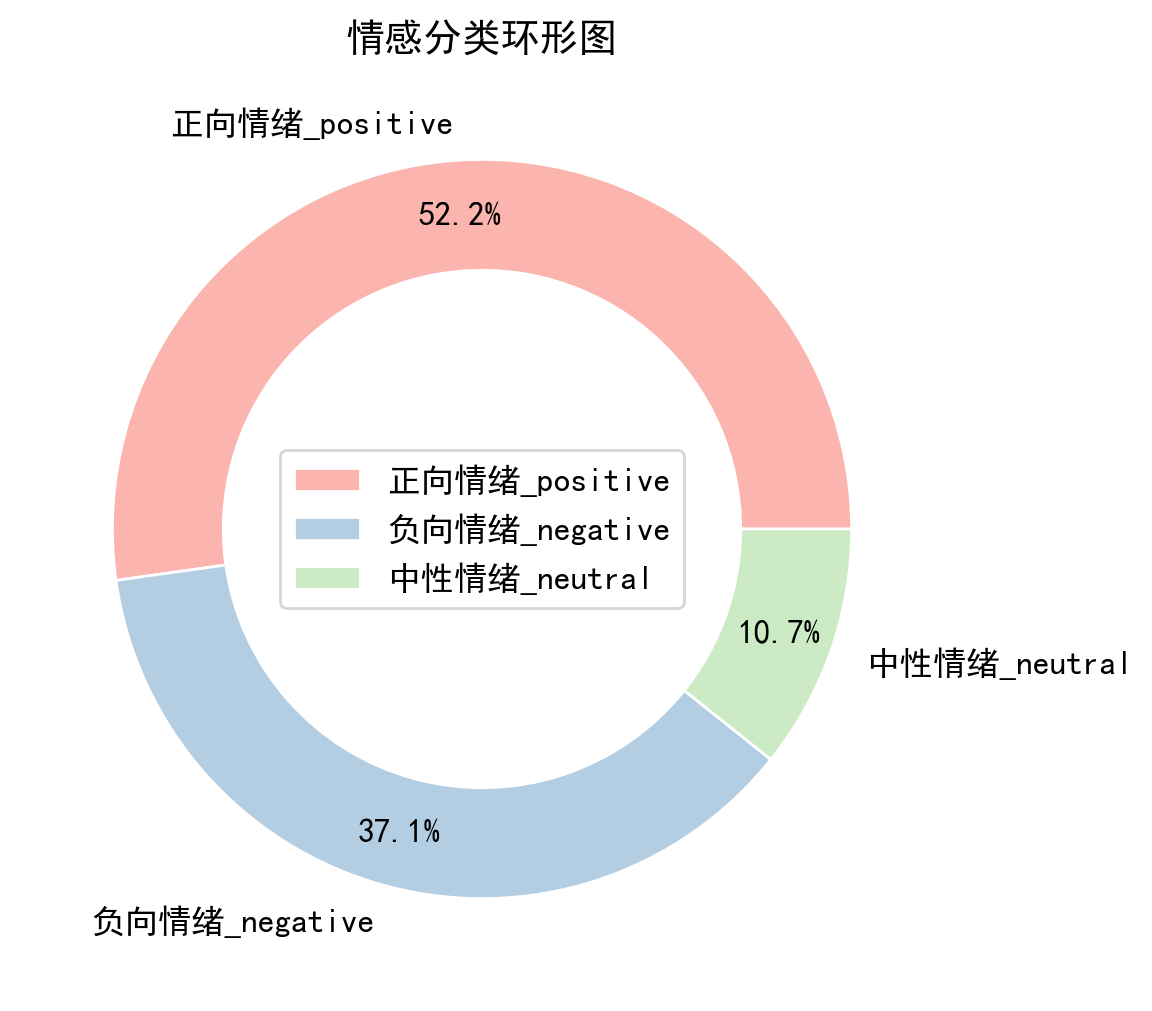

In [10]:
x = ['正向情绪_positive', '负向情绪_negative','中性情绪_neutral']
y = [a.shape[0],c.shape[0],b.shape[0]]
plt.figure(dpi=200,figsize=(10, 6)) #设置画布大小
plt.pie(y,pctdistance=0.85,autopct='%.1f%%', textprops={'fontsize': 12},labels=x, colors=Pastel1_7.hex_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.legend(x,loc='center',fontsize=12)
plt.title('情感分类环形图',fontsize=14)
plt.savefig('D:\\情感分析\\result\\波动期情感分类环形图')
plt.show()

## 训练 

准备消极和积极情感的文本，分别为neg.txt和pos.txt

In [5]:
from snownlp import sentiment
sentiment.train('neg.txt', 'pos.txt')
sentiment.save("sentiment.marshal")

将训练好的模型sentiment.marshal放到软件snownlp工具包安装路径下